# Classification challange

In [44]:
import keras
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import InputLayer
from keras.initializers.initializers import HeNormal

import nltk
from keras.regularizers import l2
from nltk import WordNetLemmatizer, TweetTokenizer

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from collections import Counter
import re
import string

from scipy import sparse
from xgboost import XGBClassifier

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/wrex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/wrex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
X = pd.read_csv("./data/Xtrain.csv", encoding="utf-8")
y = pd.read_csv("./data/ytrain.csv", encoding="utf-8")
print(f"Shape of datasets:\n\t-X: {X.shape}\n\t-y: {y.shape}")

Shape of datasets:
	-X: (1704, 1)
	-y: (1704, 1)


In [32]:
def transform_wordnet(line):
    tweet_tokenizer = TweetTokenizer()
    wordnet = WordNetLemmatizer()
    line_arr = tweet_tokenizer.tokenize(line)
    line_net_arr = [wordnet.lemmatize(word, pos='v') for word in line_arr]
    line = " ".join(line_net_arr)

    return line

def clear_tweets(data):
    data['text'] = data['text'].apply(lambda x: x.lower())

    data['text'] = data['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

    data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', ' ', x))

    data['text'] = data['text'].apply(lambda x: re.sub(r'[' + re.escape(string.punctuation) + r']', ' ', x))

    data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

    data['text'] = data['text'].apply(lambda x: transform_wordnet(x))


    return data

In [33]:
X = clear_tweets(X)
X['sentiment'] = y.sentiment
X.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)
y = X.pop('sentiment')
X

,text
0,the coachella valley music and arts festival b...
1,the sec have delay its decision on btc exchang...
2,new article new article the second circuit rul...
3,get local news deliver to your inbox the signi...
4,advertisement for premium support please call ...
...,...
1281,bloomberg european and us equity index futures...
1282,sbi vc trade the digital asset division of the...
1283,fund next gen business journalism with a month...
1284,ripple chief legal officer stuart alderoty rec...


In [34]:
y

0       0
1       2
2       2
3       0
4       0
       ..
1281    0
1282    2
1283    0
1284    0
1285    2
Name: sentiment, Length: 1286, dtype: int64

In [35]:
def my_tokenizer(text):
    tweet_tokenizer = TweetTokenizer()
    return tweet_tokenizer.tokenize(text)

tfidf_vectorizer = TfidfVectorizer(analyzer='word',tokenizer=my_tokenizer,stop_words='english', norm='l2')

X_tfidf:sparse.csr_matrix = tfidf_vectorizer.fit_transform(X['text'].values)

/opt/miniconda3/envs/bobot_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


> NOTE: now we have cleared from whitespaces and junks text, with the wordnet synonims in order to make text more generic

# Visualization

In [36]:
def visualize_history(history):
    acc_hist = history.history['accuracy']
    val_acc_hist = history.history['val_accuracy']
    loss_hist = history.history['loss']
    val_loss_hist = history.history['val_loss']

    plt.plot(acc_hist, label='accuracy')
    plt.plot(val_acc_hist, label='validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(loss_hist, label='loss')
    plt.plot(val_loss_hist, label='validation loss')
    plt.legend()
    plt.show()

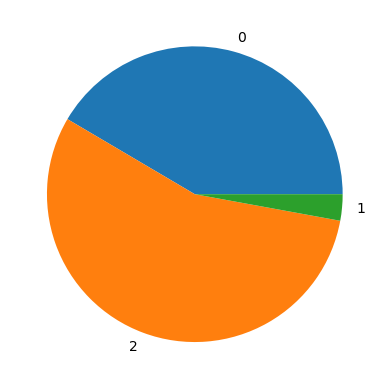

In [37]:
from collections import Counter

y_count = Counter(y)
plt.pie(y_count.values(), labels=y_count.keys())
plt.show()

# Predictions

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y.values.reshape(-1,), test_size=0.2, random_state=42, stratify=y.values)

In [39]:
def check_score(y_true, y_pred):
    print(f"F1Score: {f1_score(y_true, y_pred, average='macro')}")

In [40]:
model = LogisticRegression(penalty='l2', solver='sag', multi_class='multinomial')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

check_score(y_test, y_pred)

F1Score: 0.5670711948738855


/opt/miniconda3/envs/bobot_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [64]:
model = XGBClassifier(n_estimators=500, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
check_score(y_test, y_pred)

F1Score: 0.624616729298708


# FFNN - Keras

In [47]:
def build_model():
    model = Sequential()

    model.add(Dense(100, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001),input_shape=(X_tfidf.shape[1],)))

    model.add(Dense(50, activation='relu',kernel_initializer=HeNormal()))

    model.add(Dense(100, activation='relu', kernel_initializer=HeNormal()))


    model.add(Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [59]:
model = build_model()
hist = model.fit(X_train.toarray(),
                 y_train,validation_data=(X_test.toarray(),y_test),
                 epochs=60,
                 batch_size=12)
y_pred = model.predict(X_test.toarray())

Epoch 1/60
43/43 [==============================] - 1s 11ms/step - loss: 0.7628 - accuracy: 0.7996 - val_loss: 0.4864 - val_accuracy: 0.8372
Epoch 2/60
43/43 [==============================] - 0s 6ms/step - loss: 0.3080 - accuracy: 0.9193 - val_loss: 0.4938 - val_accuracy: 0.8295
Epoch 3/60
43/43 [==============================] - 0s 6ms/step - loss: 0.1788 - accuracy: 0.9601 - val_loss: 0.5495 - val_accuracy: 0.8217
Epoch 4/60
43/43 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.9660 - val_loss: 0.6308 - val_accuracy: 0.8295
Epoch 5/60
43/43 [==============================] - 0s 6ms/step - loss: 0.1116 - accuracy: 0.9815 - val_loss: 0.5751 - val_accuracy: 0.8566
Epoch 6/60
43/43 [==============================] - 0s 7ms/step - loss: 0.0777 - accuracy: 0.9942 - val_loss: 0.5693 - val_accuracy: 0.8566
Epoch 7/60
43/43 [==============================] - 0s 6ms/step - loss: 0.0658 - accuracy: 0.9942 - val_loss: 0.6122 - val_accuracy: 0.8450
Epoch 8/60
43/43 [=

In [61]:
y_pred_class = np.argmax(y_pred, axis=1)

In [62]:
check_score(y_test, y_pred_class)

F1Score: 0.566344205333375


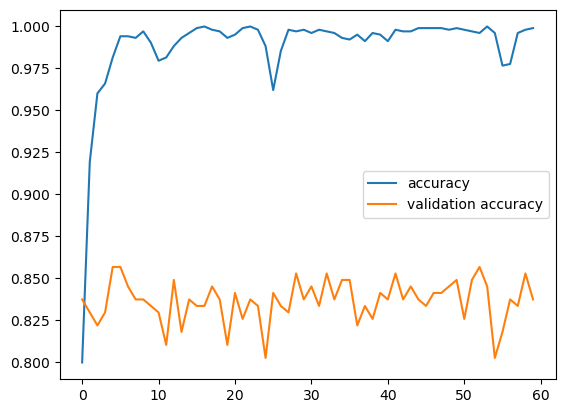

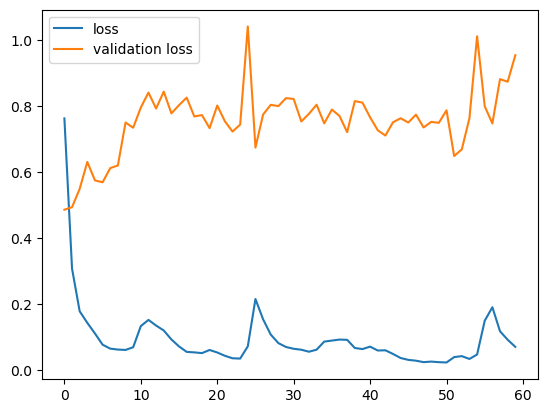

In [63]:
visualize_history(hist)